In [1]:
# This demo covers a multi-class classification problem. This is 
# somewhat more complicated, so the UI is slightly different, but 
# the general ideas are the same. The APIs may be used in the same
# way; only the metrics, tables, plots and other information 
# presented will be different.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from threshold_tuner import ClassificationThresholdTuner

In [3]:
NUM_ROWS = 10_000

In [4]:
# Simple example with 3 true classes, each covering 1/3 of the records. 
# The predictions are accurate, but not perfect. The predictions for the
# true class (once normalized) tend to be fairly low. 
def generate_data_3a():
    num_rows_per_class = NUM_ROWS // 3
    np.random.seed(0)
    d = pd.DataFrame({"Y": ['A']*num_rows_per_class + ['B']*num_rows_per_class + ['C']*num_rows_per_class,
                  "Pred_Proba_A": 
                      np.random.normal(0.9, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(0.1, 0.3, num_rows_per_class * 2).tolist(),
                  "Pred_Proba_B": 
                      np.random.normal(0.1, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(0.9, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(0.1, 0.3, num_rows_per_class).tolist(),
                  "Pred_Proba_C": 
                      np.random.normal(0.1, 0.3, num_rows_per_class*2).tolist() + \
                      np.random.normal(0.9, 0.3, num_rows_per_class).tolist()                    
                 })
    d['Y'] = d['Y'].astype(str)
    return d, ['A', 'B', 'C']

# Similar to 3a, but here we have a logical default class
def generate_data_3b():
    num_rows_for_default = int(NUM_ROWS * 0.9) 
    num_rows_per_class = (NUM_ROWS - num_rows_for_default) // 2
    np.random.seed(0)
    d = pd.DataFrame({"Y": ['No Attack']*num_rows_for_default + ['Attack A']*num_rows_per_class + ['Attack B']*num_rows_per_class,
                  "Pred_Proba No Attack": 
                      np.random.normal(0.7, 0.3, num_rows_for_default).tolist() + \
                      np.random.normal(0.5, 0.3, num_rows_per_class * 2).tolist(),
                  "Pred_Proba Attack A": 
                      np.random.normal(0.1, 0.3, num_rows_for_default).tolist() + \
                      np.random.normal(0.9, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(0.1, 0.3, num_rows_per_class).tolist(),
                  "Pred_Proba Attack B": 
                      np.random.normal(0.1, 0.3, num_rows_for_default).tolist() + \
                      np.random.normal(0.1, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(0.9, 0.3, num_rows_per_class).tolist()                    
                 })
    d['Y'] = d['Y'].astype(str)
    return d, ['No Attack', 'Attack A', 'Attack B']

# Generate a dataset with 10 classes.
def generate_data_10():
    num_rows_for_default = int(NUM_ROWS * 0.9)
    num_rows_per_class = (NUM_ROWS - num_rows_for_default) // 9
    np.random.seed(0)
    d = pd.DataFrame({
        "Y": ['No Attack']*num_rows_for_default + ['Attack 1']*num_rows_per_class + ['Attack 2']*num_rows_per_class +\
             ['Attack 3']*num_rows_per_class + ['Attack 4']*num_rows_per_class + ['Attack 5']*num_rows_per_class + \
             ['Attack 6']*num_rows_per_class + ['Attack 7']*num_rows_per_class + ['Attack 8']*num_rows_per_class + \
             ['Attack 9']*num_rows_per_class,
        "Pred_Proba No Attack":
            np.random.normal(0.7, 0.3, num_rows_for_default).tolist() + \
            np.random.normal(0.5, 0.3, num_rows_per_class * 9).tolist(),
    })

    for i in range(9):
        num_rows_classes_before = num_rows_per_class * (i)
        num_rows_classes_after = num_rows_per_class * (9-i-1)

        d[f"Pred_Proba Attack {i+1}"] = \
          np.random.normal(0.1, 0.3, num_rows_for_default + num_rows_classes_before).tolist() + \
          np.random.normal(0.9, 0.3, num_rows_per_class).tolist() + \
          np.random.normal(0.1, 0.3, num_rows_classes_after).tolist()

    d['Y'] = d['Y'].astype(str)
    return d, ['No Attack', 'Attack 1', 'Attack 2', 'Attack 3', 'Attack 4', 'Attack 5', 'Attack 6', 'Attack 7', 'Attack 8', 'Attack 9']


# Test with 3 classes

In [5]:
d, target_classes = generate_data_3b()

In [6]:
target_classes

['No Attack', 'Attack A', 'Attack B']

In [7]:
# Ensure the probabilities are between 0.0 and 1.0. It is possible for the scores coming
# from MinMaxScaler to be slighly outside this range.

scaler= MinMaxScaler()
proba_cols = [x for x in d.columns if "Proba" in x]

for col_name in proba_cols:
    d[col_name] = scaler.fit_transform(d[col_name].values.reshape(-1, 1)).reshape(1, -1)[0]
    d[col_name] = [x if x <= 1.0 else 1.0 for x in d[col_name]]
    d[col_name] = [x if x >= 0.0 else 0.0 for x in d[col_name]]
  
   
# Ensure the probabilities sum to 1.0
d['Sum'] = d[proba_cols].sum(axis=1)
for col_name in proba_cols:
    d[col_name] = d[col_name] / d['Sum']
d['Sum'] = d[proba_cols].sum(axis=1)
d = d.drop(columns=["Sum"])

In [8]:
# Set the Binary prediction column based on the 
# class with the highest prediction (no threshold used).

def set_class_prediction(d):    
    max_cols = d[proba_cols].idxmax(axis=1)
    max_cols = [x[len("Pred_Proba_"):] for x in max_cols]
    return max_cols   

d['Pred'] = set_class_prediction(d)   
d

Y  Pred_Proba No Attack  Pred_Proba Attack A  \
0     No Attack              0.459605             0.226221   
1     No Attack              0.419347             0.224810   
2     No Attack              0.361314             0.322421   
3     No Attack              0.466122             0.234884   
4     No Attack              0.562942             0.273863   
...         ...                   ...                  ...   
9995   Attack B              0.132193             0.321736   
9996   Attack B              0.283767             0.253315   
9997   Attack B              0.332538             0.261336   
9998   Attack B              0.267985             0.180196   
9999   Attack B              0.324897             0.194176   

      Pred_Proba Attack B       Pred  
0                0.314174  No Attack  
1                0.355843  No Attack  
2                0.316265  No Attack  
3                0.298994  No Attack  
4                0.163195  No Attack  
...                   ...        ...  
9995             0.546071   Attack B  
9996             0.462917   Attack B  
9997             0.406125   Attack B  
9998             0.551819   Attack B  
9999             0.480928   Attack B  

[10000 rows x 5 columns]

In [9]:
d['Pred'].value_counts()

No Attack    4654
Attack B     3815
Attack A     1531
Name: Pred, dtype: int64

# Test the visualizations

In [10]:
tuner = ClassificationThresholdTuner()

Metric  No Attack  Attack A  Attack B     Macro
0  Precision   0.991190  0.293272  0.127130  0.470531
0     Recall   0.512556  0.898000  0.970000  0.793519
0         F1   0.675699  0.442147  0.224797  0.447548

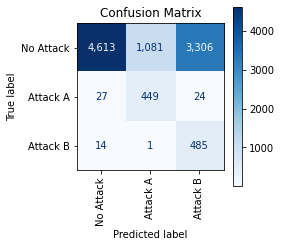

In [11]:
# Simple output based on the predicted classes

tuner.print_stats_labels(
    y_true=d["Y"], 
    target_classes=target_classes,
    y_pred=d["Pred"])

Metric  No Attack  Attack A  Attack B     Macro
0  Precision   0.991190  0.293272  0.127130  0.470531
0     Recall   0.512556  0.898000  0.970000  0.793519
0         F1   0.675699  0.442147  0.224797  0.447548

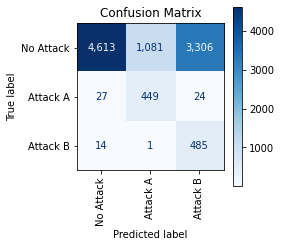

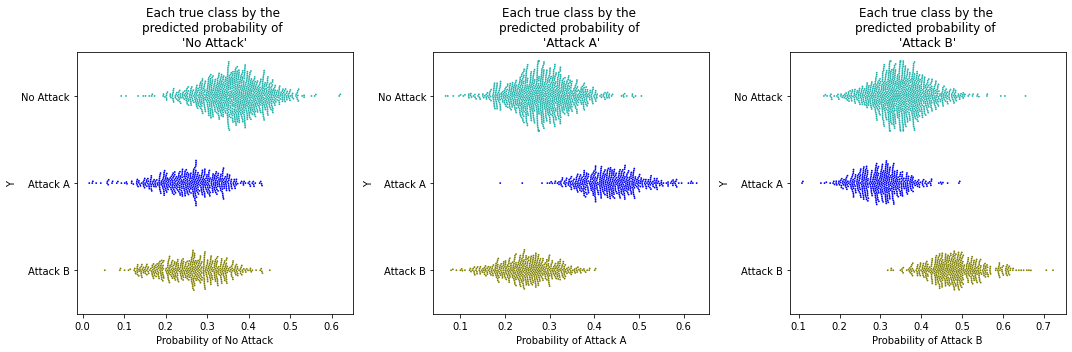

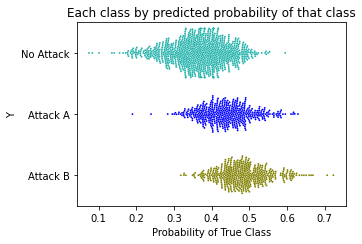

In [12]:
# Simple output based on the predicted probabilities for each class
# Here, the predictions tend to be highest for the true class, but only
# about 0.4 to 0.5, while the other two classes will have probabilities 
# around 0.25. 

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    default_class=None,
    thresholds=None
)    

Metric  No Attack  Attack A  Attack B     Macro
0  Precision   0.974921  0.496561  0.195289  0.555590
0     Recall   0.751556  0.722000  0.912000  0.795185
0         F1   0.848789  0.588427  0.321693  0.586303

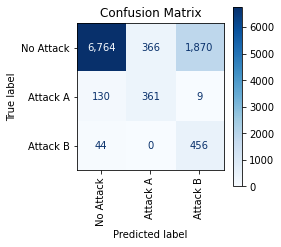

......................................................................................


## Examining the results in terms of class 'No Attack' (the default class) vs all

Metric     Score
0  Brier Score  0.373733
1        AUROC  0.842848

Brier score and AUROC calculated based on predicting 'No Attack', vs not 'No Attack', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (No Attack). This shows which classes were predicted when No Attack is true. This corresponds to the row for No Attack in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

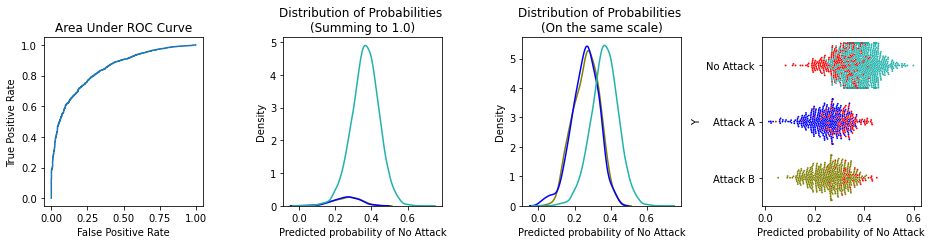

......................................................................................


## Examining the results in terms of class 'Attack A' vs all

Metric     Score
0  Brier Score  0.095974
1        AUROC  0.956719

Brier score and AUROC calculated based on predicting 'Attack A', vs not 'Attack A', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack A). This shows which classes were predicted when Attack A is true. This corresponds to the row for Attack A in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

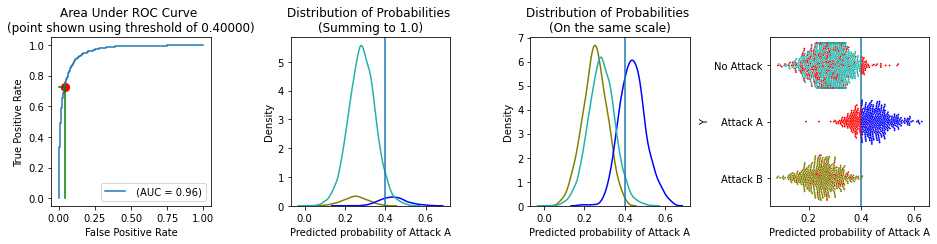

......................................................................................


## Examining the results in terms of class 'Attack B' vs all

Metric     Score
0  Brier Score  0.132053
1        AUROC  0.934239

Brier score and AUROC calculated based on predicting 'Attack B', vs not 'Attack B', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack B). This shows which classes were predicted when Attack B is true. This corresponds to the row for Attack B in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

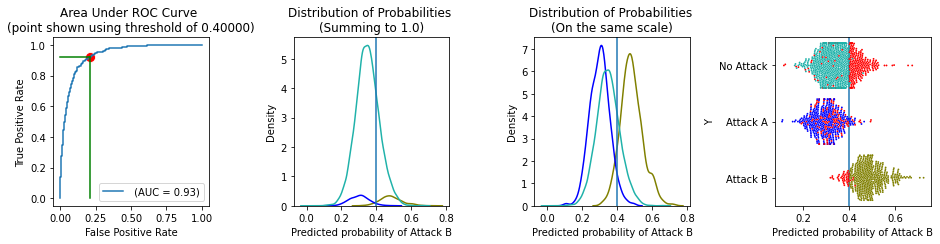

In [13]:
# Here we demonstrate the same, but providing a set of thresholds. 
# As this is multi-class classification, it's necessary to 
# also set a default class. The threshold for the default
# class is not used and is usually set to 0.0. This sets
# the thresholds for the other 2 classes to 0.4 (selected
# somewhat randomly and just for demonstration).

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack',
    thresholds=[0.0, 0.4, 0.4]
)  

# Tools to help adjust the threshold

Displaying thresholds where a common threshold is applied to all classes (other than the default class). Red indicates misclassified records.

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.67s/it]


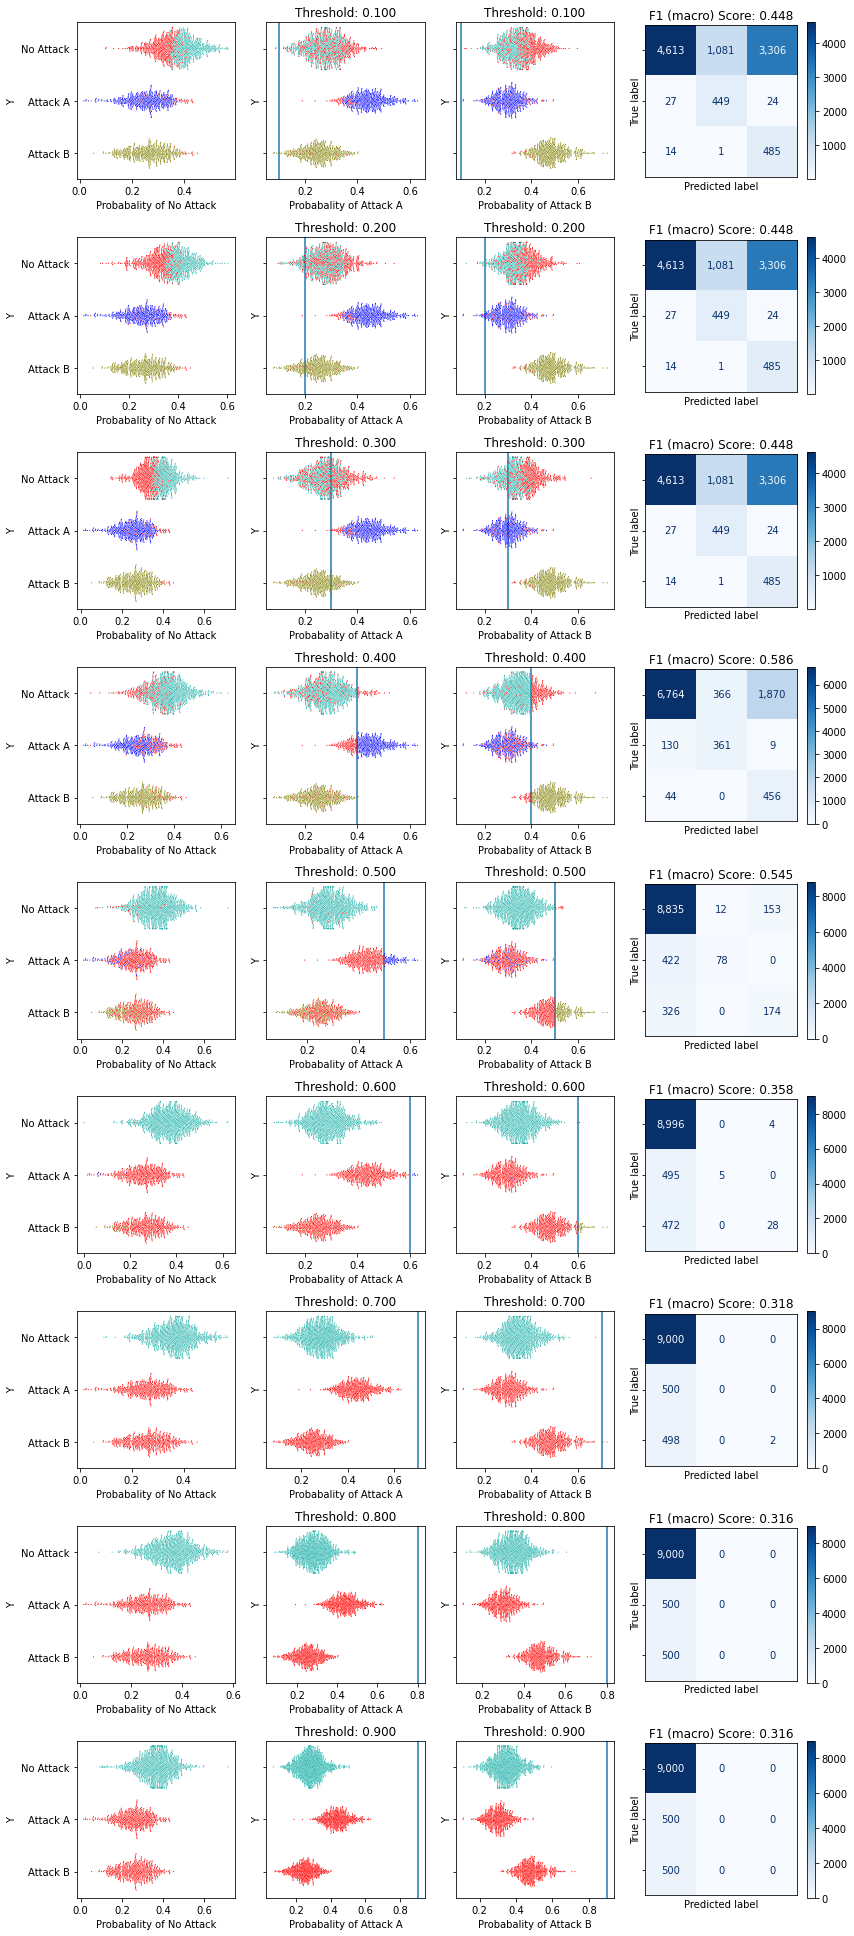

In [14]:
# View the effect of different thresholds for a specified
# set of thresholds. This uses the default set of 0.1, 0.2,
# 0.3...up to 0.9.
# This is multiclass classification, so it is necessary to 
# set the default class. 

tuner.plot_by_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack'
)

In [15]:
# Notes:

# As the threshold is increseased, more and more of the records where the true
# class is the default (No Attack) are labelled correctly. 

# When the threshold is quite low, such as 0.1, then of those records where the 
# true class is the default, only those with the highest predicted probability of 
# the class being No Attack (about the top half) were predicted correctly. 

# Once the threshold is set above 0.6, everything is predicted as the default class,
# so all cases where the ground truth is the default class are correct and all others
# are incorrect. 

# Attack A and B are generally predicted correctly when using low thresholds,
# but mostly incorrectly when using higher thresholds. 

# As expected,, setting the threshold higher meeans prediting the default class 
# more often and missing less of these, though missing more of the other classes. 

In [16]:
# Allow ClassificationThesholdTuner to identify the best threshold optimizing
# for a specified metric, in this example, f1 score (macro).
# The threshold for the default class will always be set to 0.0.

from sklearn.metrics import f1_score

best_thresholds = tuner.tune_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    metric=f1_score,
    average='macro',
    higher_is_better=True,
    default_class='No Attack',
    max_iterations=5
)
best_thresholds

 40%|█████████████████████████████████▌                                                  | 2/5 [00:14<00:22,  7.35s/it]


[0.0, 0.4125700000000003, 0.4714286]

In [17]:
tuned_pred = tuner.get_predictions(target_classes, d[proba_cols], 'No Attack', best_thresholds)

# Display the first 10 predictions
tuned_pred[:10]

['No Attack',
 'No Attack',
 'No Attack',
 'No Attack',
 'No Attack',
 'No Attack',
 'No Attack',
 'No Attack',
 'No Attack',
 'No Attack']

Metric  No Attack  Attack A  Attack B     Macro
0  Precision   0.956209  0.571924  0.434251  0.654128
0     Recall   0.931667  0.660000  0.568000  0.719889
0         F1   0.943778  0.612813  0.492201  0.682931

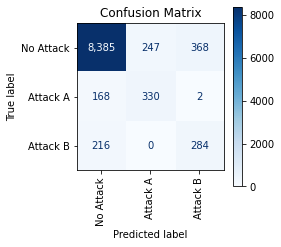

......................................................................................


## Examining the results in terms of class 'No Attack' (the default class) vs all

Metric     Score
0  Brier Score  0.373733
1        AUROC  0.842848

Brier score and AUROC calculated based on predicting 'No Attack', vs not 'No Attack', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (No Attack). This shows which classes were predicted when No Attack is true. This corresponds to the row for No Attack in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

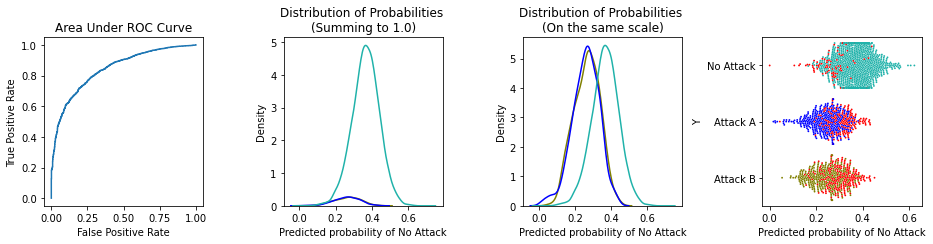

......................................................................................


## Examining the results in terms of class 'Attack A' vs all

Metric     Score
0  Brier Score  0.095974
1        AUROC  0.956719

Brier score and AUROC calculated based on predicting 'Attack A', vs not 'Attack A', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack A). This shows which classes were predicted when Attack A is true. This corresponds to the row for Attack A in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

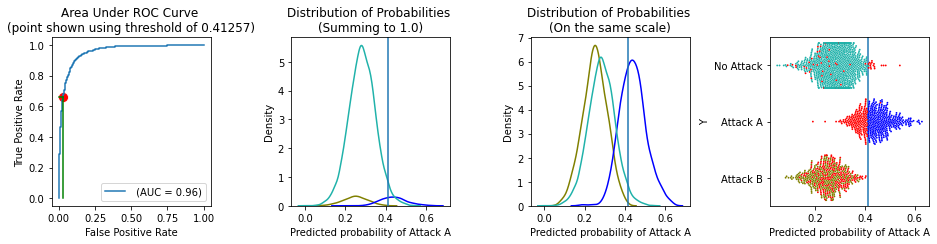

......................................................................................


## Examining the results in terms of class 'Attack B' vs all

Metric     Score
0  Brier Score  0.132053
1        AUROC  0.934239

Brier score and AUROC calculated based on predicting 'Attack B', vs not 'Attack B', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack B). This shows which classes were predicted when Attack B is true. This corresponds to the row for Attack B in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

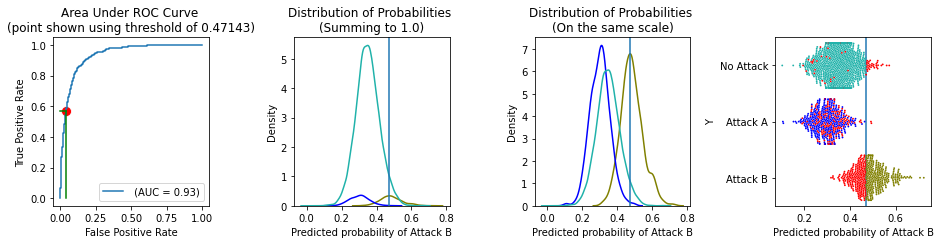

In [18]:
# Call print_stats_proba() again, this time with the best thresholds.
# The macro F1 score has improved from about 0.44 to 0.68 (results
# will vary slightly from run to run).

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack',
    thresholds=best_thresholds
) 

# Test with 10 classes

In [19]:
d, target_classes = generate_data_10()

In [20]:
scaler= MinMaxScaler()
proba_cols = [x for x in d.columns if "Proba" in x]

for col_name in proba_cols:
    d[col_name] = scaler.fit_transform(d[col_name].values.reshape(-1, 1)).reshape(1, -1)[0]
    d[col_name] = [x if x <= 1.0 else 1.0 for x in d[col_name]]
    d[col_name] = [x if x >= 0.0 else 0.0 for x in d[col_name]]
  
   
# Ensure the probabilities sum to 1.0
d['Sum'] = d[proba_cols].sum(axis=1)
for col_name in proba_cols:
    d[col_name] = d[col_name] / d['Sum']
d['Sum'] = d[proba_cols].sum(axis=1)
d = d.drop(columns=["Sum"])

In [21]:
target_classes

['No Attack',
 'Attack 1',
 'Attack 2',
 'Attack 3',
 'Attack 4',
 'Attack 5',
 'Attack 6',
 'Attack 7',
 'Attack 8',
 'Attack 9']

Metric  No Attack  Attack 1  Attack 2  Attack 3  Attack 4  Attack 5  \
0  Precision   0.990817  0.229917  0.051777  0.120715  0.142857  0.081287   
0     Recall   0.239778  0.747748  0.918919  0.729730  0.801802  0.864865   
0         F1   0.386116  0.351695  0.098030  0.207161  0.242507  0.148607   

   Attack 6  Attack 7  Attack 8  Attack 9     Macro  
0  0.309091  0.079782  0.092955  0.126866  0.222606  
0  0.612613  0.792793  0.855856  0.765766  0.732987  
0  0.410876  0.144975  0.167696  0.217670  0.237533

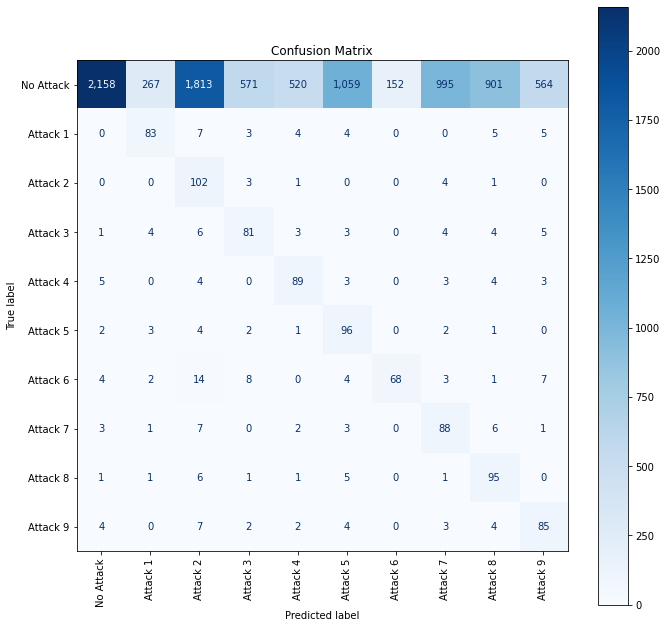

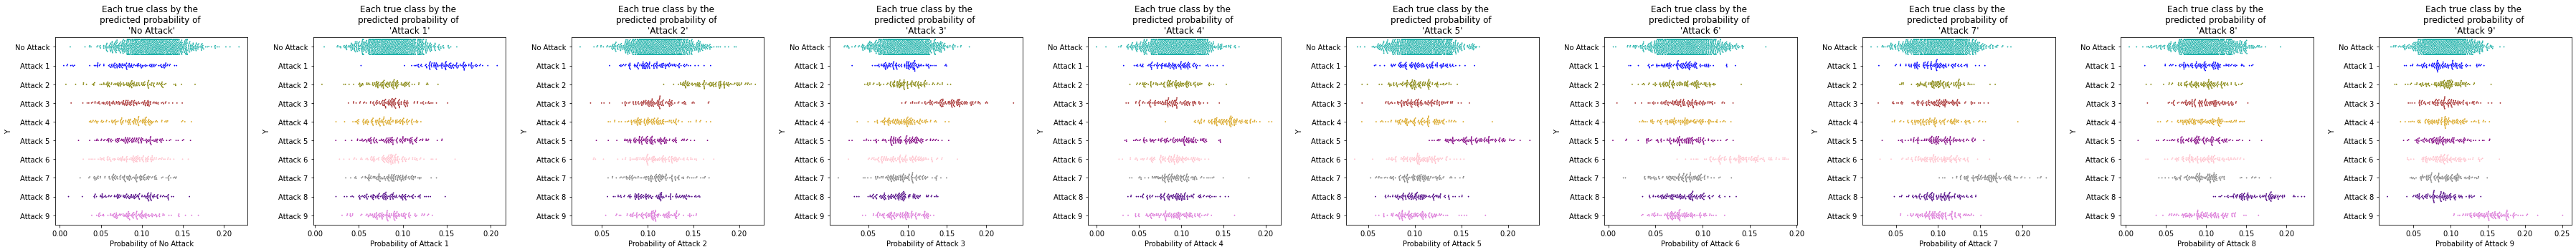

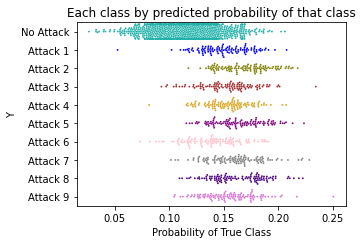

In [22]:
tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    default_class=None,
    thresholds=None
)    

Metric  No Attack  Attack 1  Attack 2  Attack 3  Attack 4  Attack 5  \
0  Precision   0.990817  0.229917  0.051777  0.120715  0.142857  0.081287   
0     Recall   0.239778  0.747748  0.918919  0.729730  0.801802  0.864865   
0         F1   0.386116  0.351695  0.098030  0.207161  0.242507  0.148607   

   Attack 6  Attack 7  Attack 8  Attack 9     Macro  
0  0.309091  0.079782  0.092955  0.126866  0.222606  
0  0.612613  0.792793  0.855856  0.765766  0.732987  
0  0.410876  0.144975  0.167696  0.217670  0.237533

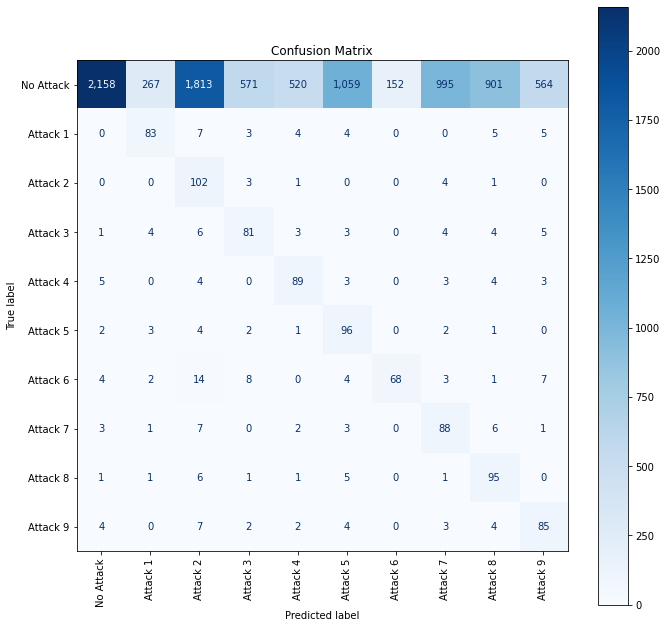

......................................................................................


## Examining the results in terms of class 'No Attack' (the default class) vs all

Metric     Score
0  Brier Score  0.708314
1        AUROC  0.738112

Brier score and AUROC calculated based on predicting 'No Attack', vs not 'No Attack', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (No Attack). This shows which classes were predicted when No Attack is true. This corresponds to the row for No Attack in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

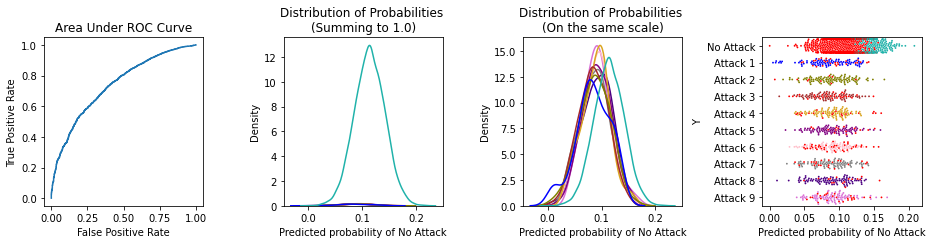

......................................................................................


## Examining the results in terms of class 'Attack 1' vs all

Metric     Score
0  Brier Score  0.016231
1        AUROC  0.971703

Brier score and AUROC calculated based on predicting 'Attack 1', vs not 'Attack 1', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 1). This shows which classes were predicted when Attack 1 is true. This corresponds to the row for Attack 1 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

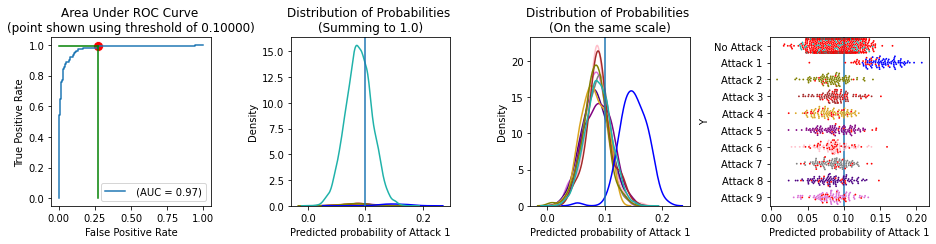

......................................................................................


## Examining the results in terms of class 'Attack 2' vs all

Metric     Score
0  Brier Score  0.021000
1        AUROC  0.959234

Brier score and AUROC calculated based on predicting 'Attack 2', vs not 'Attack 2', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 2). This shows which classes were predicted when Attack 2 is true. This corresponds to the row for Attack 2 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

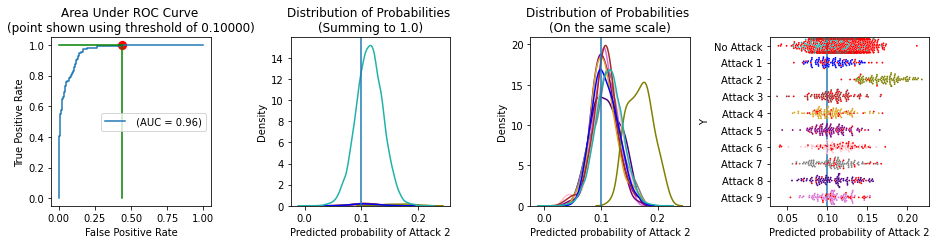

......................................................................................


## Examining the results in terms of class 'Attack 3' vs all

Metric     Score
0  Brier Score  0.017882
1        AUROC  0.945175

Brier score and AUROC calculated based on predicting 'Attack 3', vs not 'Attack 3', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 3). This shows which classes were predicted when Attack 3 is true. This corresponds to the row for Attack 3 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

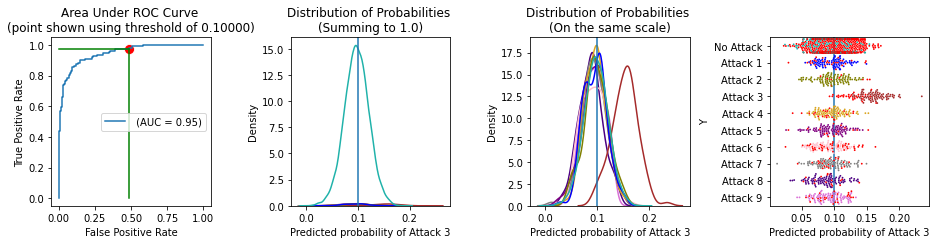

......................................................................................


## Examining the results in terms of class 'Attack 4' vs all

Metric     Score
0  Brier Score  0.017494
1        AUROC  0.967040

Brier score and AUROC calculated based on predicting 'Attack 4', vs not 'Attack 4', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 4). This shows which classes were predicted when Attack 4 is true. This corresponds to the row for Attack 4 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

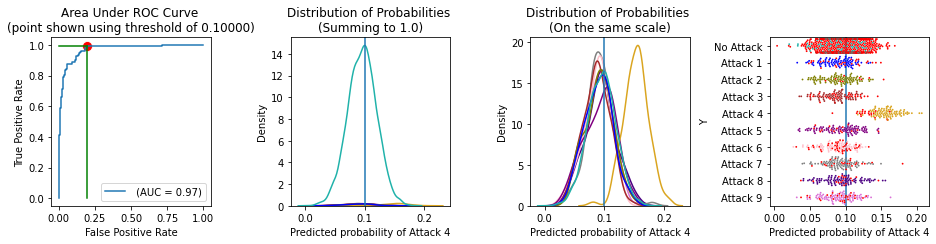

......................................................................................


## Examining the results in terms of class 'Attack 5' vs all

Metric     Score
0  Brier Score  0.019790
1        AUROC  0.963164

Brier score and AUROC calculated based on predicting 'Attack 5', vs not 'Attack 5', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 5). This shows which classes were predicted when Attack 5 is true. This corresponds to the row for Attack 5 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

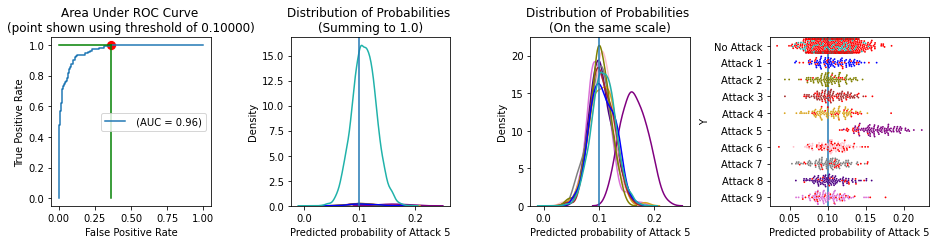

......................................................................................


## Examining the results in terms of class 'Attack 6' vs all

Metric     Score
0  Brier Score  0.015412
1        AUROC  0.955728

Brier score and AUROC calculated based on predicting 'Attack 6', vs not 'Attack 6', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 6). This shows which classes were predicted when Attack 6 is true. This corresponds to the row for Attack 6 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

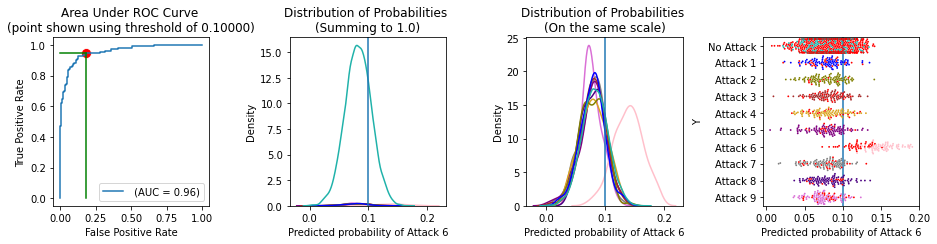

......................................................................................


## Examining the results in terms of class 'Attack 7' vs all

Metric     Score
0  Brier Score  0.018842
1        AUROC  0.955375

Brier score and AUROC calculated based on predicting 'Attack 7', vs not 'Attack 7', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 7). This shows which classes were predicted when Attack 7 is true. This corresponds to the row for Attack 7 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

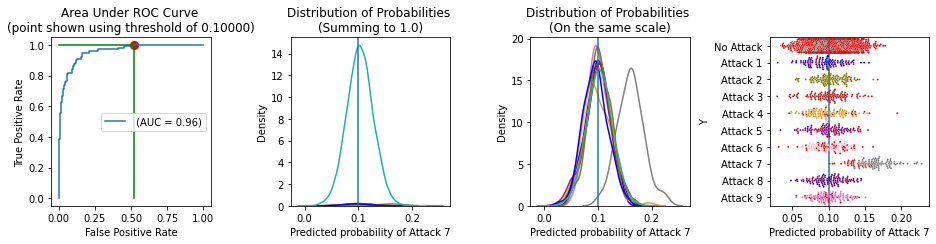

......................................................................................


## Examining the results in terms of class 'Attack 8' vs all

Metric     Score
0  Brier Score  0.018475
1        AUROC  0.960850

Brier score and AUROC calculated based on predicting 'Attack 8', vs not 'Attack 8', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 8). This shows which classes were predicted when Attack 8 is true. This corresponds to the row for Attack 8 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

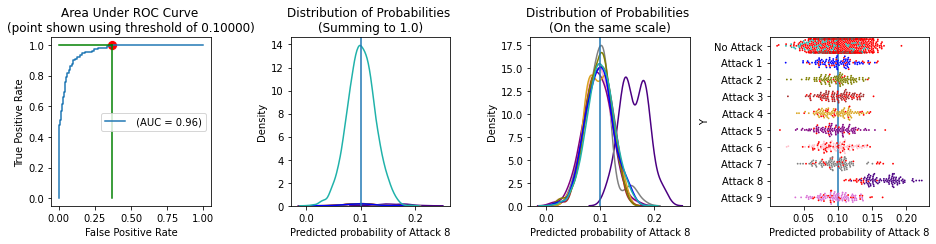

......................................................................................


## Examining the results in terms of class 'Attack 9' vs all

Metric     Score
0  Brier Score  0.017401
1        AUROC  0.964061

Brier score and AUROC calculated based on predicting 'Attack 9', vs not 'Attack 9', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 9). This shows which classes were predicted when Attack 9 is true. This corresponds to the row for Attack 9 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

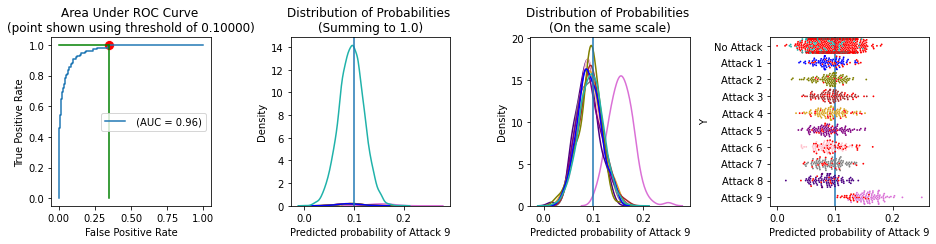

In [23]:
# This shows an example if 0.1 (selected randomly for this demonstration)
# were used as the threshold for all classes (other than the default).
# We can see in the plots, 0.1 is likely too low for most classes. 

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack',
    thresholds=[0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
)  

Displaying thresholds where a common threshold is applied to all classes (other than the default class). Red indicates misclassified records.

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:02<00:00, 17.45s/it]


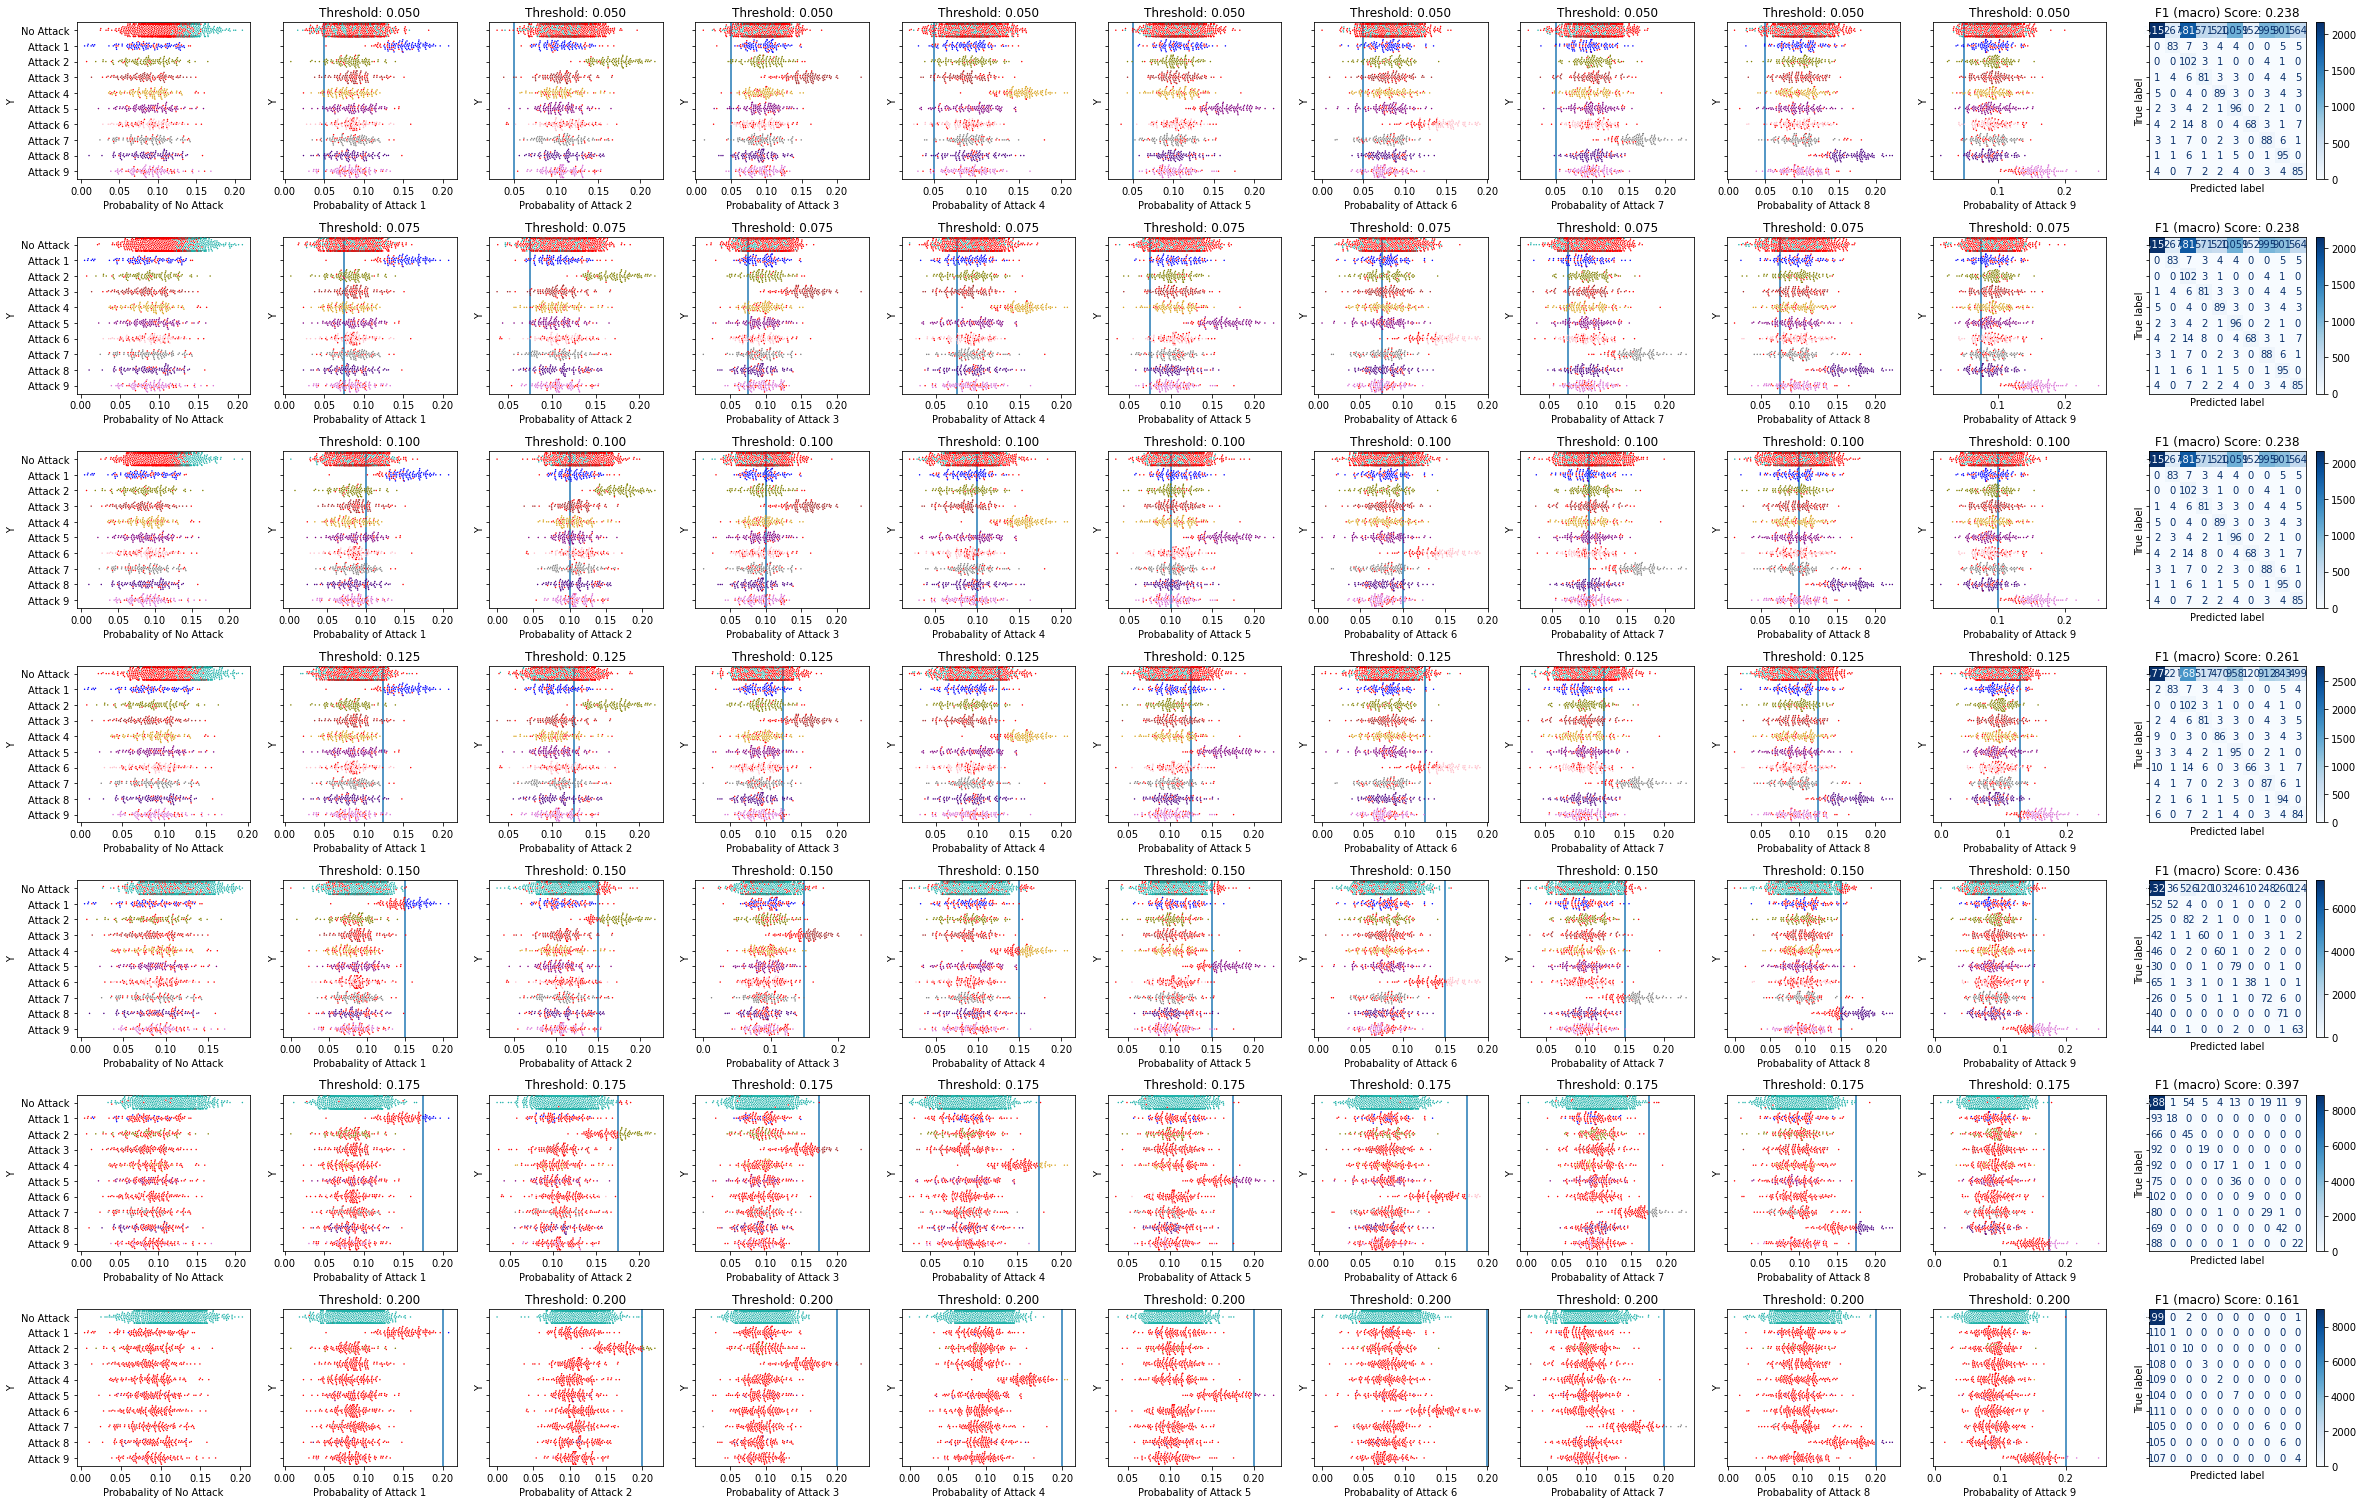

In [24]:
# Call plot_by_threshold() with the default settings, which plots
# using thresholds of 0.1, 0.

tuner.plot_by_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack',
    start=0.05, end=0.20, num_steps=7
)

In [25]:
from sklearn.metrics import f1_score

best_thresholds = tuner.tune_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    metric=f1_score,
    average='macro',
    higher_is_better=True,
    default_class='No Attack',
    max_iterations=5
)
best_thresholds

 20%|████████████████▊                                                                   | 1/5 [01:09<04:37, 69.32s/it]


[0.0,
 0.15319999999999995,
 0.2,
 0.2,
 0.2,
 0.2,
 0.13762000000000002,
 0.2,
 0.2,
 0.2]

Metric  No Attack  Attack 1  Attack 2  Attack 3  Attack 4  Attack 5  \
0  Precision   0.913435  0.714286  0.833333  1.000000  1.000000  1.000000   
0     Recall   0.991889  0.450450  0.090090  0.027027  0.018018  0.063063   
0         F1   0.951047  0.552486  0.162602  0.052632  0.035398  0.118644   

   Attack 6  Attack 7  Attack 8  Attack 9     Macro  
0  0.556522  1.000000  1.000000  0.800000  0.881758  
0  0.576577  0.054054  0.054054  0.036036  0.236126  
0  0.566372  0.102564  0.102564  0.068966  0.271327

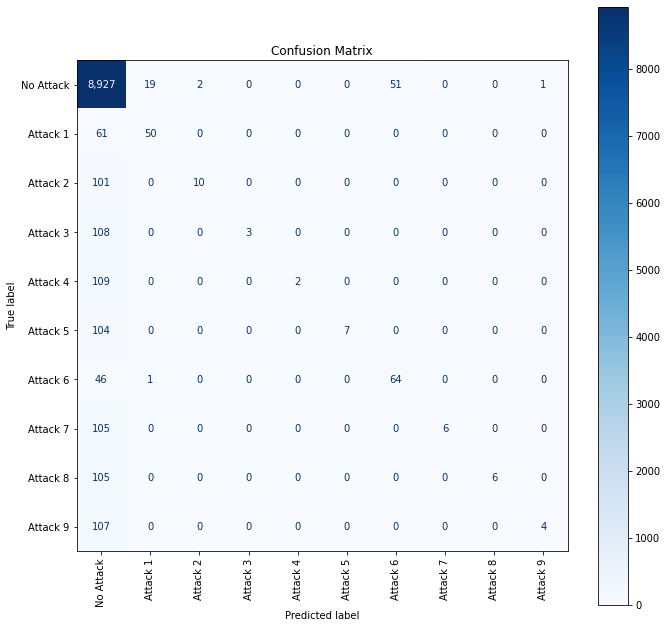

......................................................................................


## Examining the results in terms of class 'No Attack' (the default class) vs all

Metric     Score
0  Brier Score  0.708314
1        AUROC  0.738112

Brier score and AUROC calculated based on predicting 'No Attack', vs not 'No Attack', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (No Attack). This shows which classes were predicted when No Attack is true. This corresponds to the row for No Attack in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

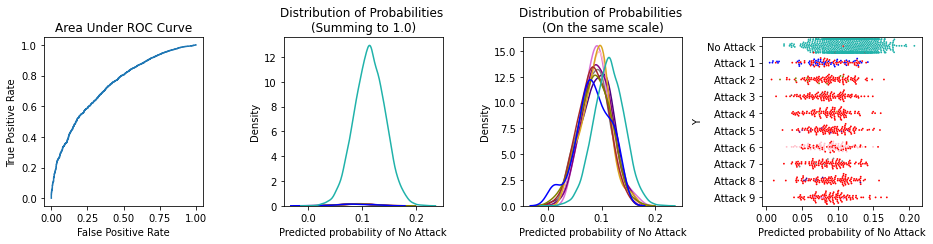

......................................................................................


## Examining the results in terms of class 'Attack 1' vs all

Metric     Score
0  Brier Score  0.016231
1        AUROC  0.971703

Brier score and AUROC calculated based on predicting 'Attack 1', vs not 'Attack 1', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 1). This shows which classes were predicted when Attack 1 is true. This corresponds to the row for Attack 1 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

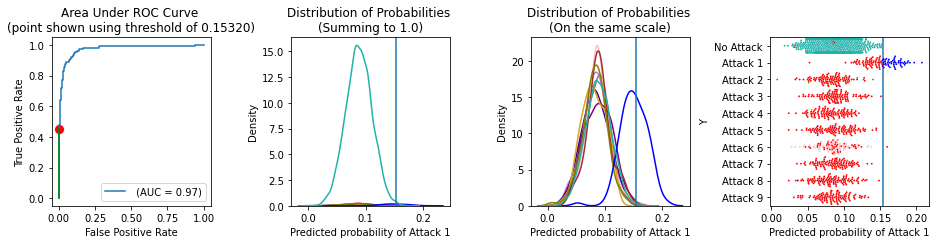

......................................................................................


## Examining the results in terms of class 'Attack 2' vs all

Metric     Score
0  Brier Score  0.021000
1        AUROC  0.959234

Brier score and AUROC calculated based on predicting 'Attack 2', vs not 'Attack 2', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 2). This shows which classes were predicted when Attack 2 is true. This corresponds to the row for Attack 2 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

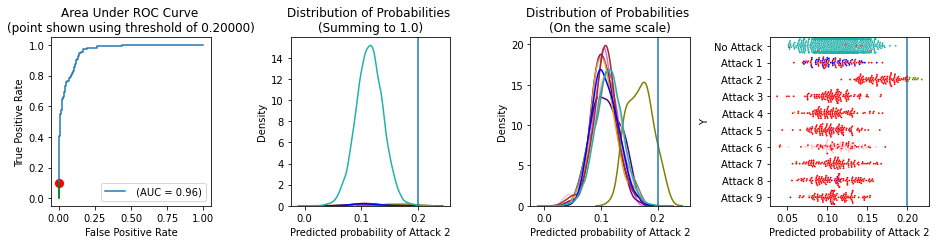

......................................................................................


## Examining the results in terms of class 'Attack 3' vs all

Metric     Score
0  Brier Score  0.017882
1        AUROC  0.945175

Brier score and AUROC calculated based on predicting 'Attack 3', vs not 'Attack 3', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 3). This shows which classes were predicted when Attack 3 is true. This corresponds to the row for Attack 3 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

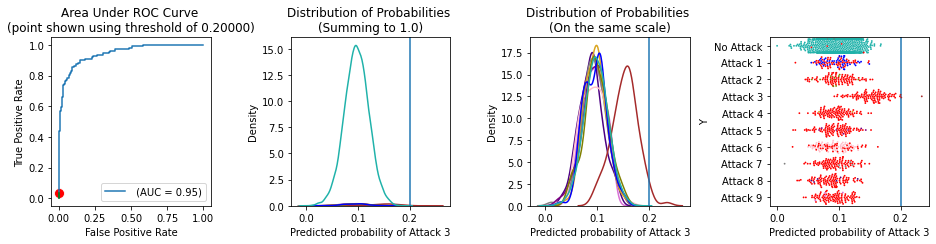

......................................................................................


## Examining the results in terms of class 'Attack 4' vs all

Metric     Score
0  Brier Score  0.017494
1        AUROC  0.967040

Brier score and AUROC calculated based on predicting 'Attack 4', vs not 'Attack 4', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 4). This shows which classes were predicted when Attack 4 is true. This corresponds to the row for Attack 4 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

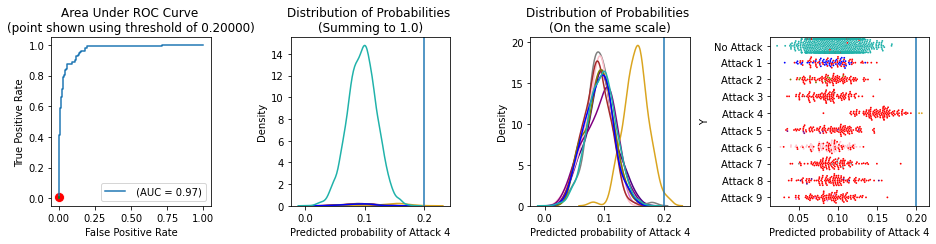

......................................................................................


## Examining the results in terms of class 'Attack 5' vs all

Metric     Score
0  Brier Score  0.019790
1        AUROC  0.963164

Brier score and AUROC calculated based on predicting 'Attack 5', vs not 'Attack 5', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 5). This shows which classes were predicted when Attack 5 is true. This corresponds to the row for Attack 5 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

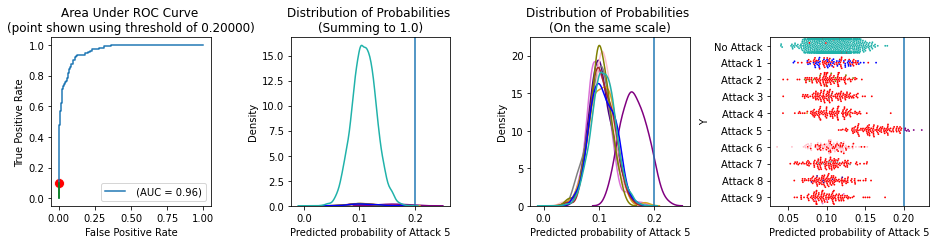

......................................................................................


## Examining the results in terms of class 'Attack 6' vs all

Metric     Score
0  Brier Score  0.015412
1        AUROC  0.955728

Brier score and AUROC calculated based on predicting 'Attack 6', vs not 'Attack 6', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 6). This shows which classes were predicted when Attack 6 is true. This corresponds to the row for Attack 6 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

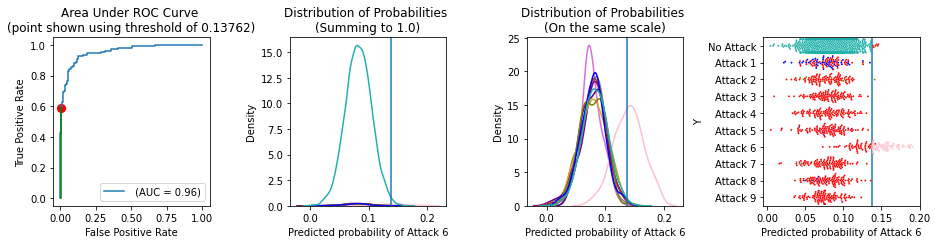

......................................................................................


## Examining the results in terms of class 'Attack 7' vs all

Metric     Score
0  Brier Score  0.018842
1        AUROC  0.955375

Brier score and AUROC calculated based on predicting 'Attack 7', vs not 'Attack 7', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 7). This shows which classes were predicted when Attack 7 is true. This corresponds to the row for Attack 7 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

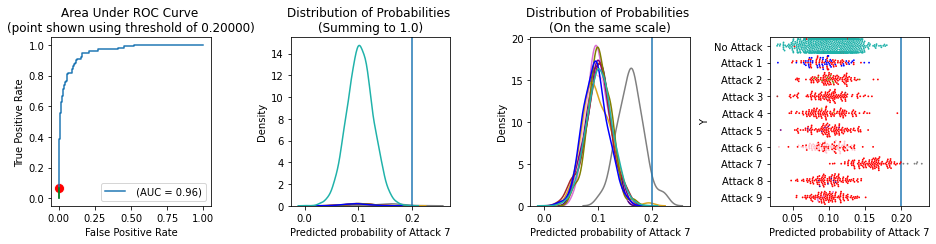

......................................................................................


## Examining the results in terms of class 'Attack 8' vs all

Metric     Score
0  Brier Score  0.018475
1        AUROC  0.960850

Brier score and AUROC calculated based on predicting 'Attack 8', vs not 'Attack 8', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 8). This shows which classes were predicted when Attack 8 is true. This corresponds to the row for Attack 8 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

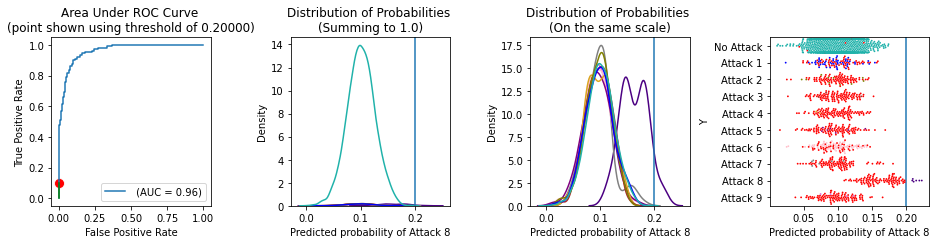

......................................................................................


## Examining the results in terms of class 'Attack 9' vs all

Metric     Score
0  Brier Score  0.017401
1        AUROC  0.964061

Brier score and AUROC calculated based on predicting 'Attack 9', vs not 'Attack 9', so calculated as a two-class problem.

<br><br>Displaying the row of the confusion matrix for the current target (Attack 9). This shows which classes were predicted when Attack 9 is true. This corresponds to the row for Attack 9 in the swarm plot and explains the predictions for the red dots in this row. Red dots in other rows in the swarm plot may predict any class other than the correct class.

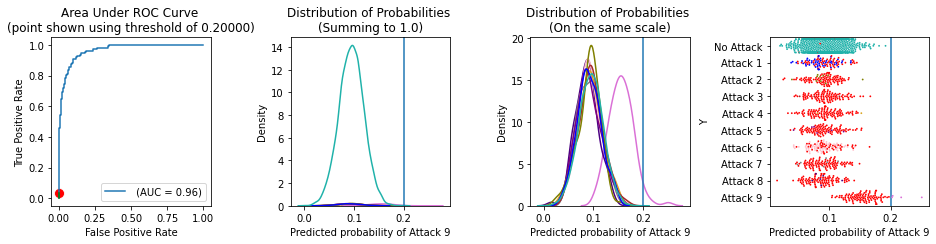

In [26]:
# With the tuned thresholds, there are drastically less records where the true
# class is 'No Attack' that are now mislabelled. The F1 macro score has improved
# from roughly 0.24 to roughly 0.27 (though it will vary each run).

# We can also see the implications of using the discovered thresholds. They do
# improve the macro F1 score (the metric specified above), but result in very 
# few predictions for classes other than 'No Attack'. This may be acceptable or 
# not, but can be seen clearly here. 

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack',
    thresholds=best_thresholds
) 